In [5]:
# Librerie principali
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch & torchvision
import torch
from torchvision import models
from torchvision.models import ResNet50_Weights

# OpenCV
import cv2

# Similarità
from sklearn.metrics.pairwise import cosine_distances

from sklearn.decomposition import PCA

from collections import defaultdict

from sklearn.preprocessing import normalize


Setup

In [6]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()


#funzione di creazione dei file
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "resnetfc_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "resnetfc_part2.npz")


Funzione Estrazione Feature - Task 1-2

In [7]:
def extract_fc_features_from_image(image_path, model, preprocess, device):
    """
    Estrae le feature del layer fully connected (fc) di ResNet50 da un'immagine.
    """
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"[ERRORE] Immagine non valida {image_path}: {e}")
        return None

    img_tensor = preprocess(img).unsqueeze(0).to(device)
    fc_output = []

    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    if fc_output:
        return fc_output[0].squeeze(0).cpu().numpy()
    else:
        print(f"[ERRORE] Nessun output FC per {image_path}")
        return None

Elaborazione Batch e Salvataggio Feature in .npz

In [8]:
def process_and_save_features(base_folder, subfolders, output_file):
    """
    Estrae le feature FC da immagini in più cartelle e salva in un file .npz.
    """
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_fc_features_from_image(img_path, model, preprocess, device)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

 Retrieval: Immagini più Simili (distanza coseno) - Task 3

In [9]:
def find_k_similar_cosine(img_path, k):
    """
    Trova le k immagini più simili rispetto a una query, usando la distanza coseno.
    """
    query_feature = extract_fc_features_from_image(img_path, model, preprocess, device)
    if query_feature is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = cosine_distances(feat_matrix_part1, query_feature).flatten()

    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {top_k_scores[rank]:.4f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.4f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
# Parametri cartelle e output
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "resnetfc_part1")
process_and_save_features("Part2", subfolders, "resnetfc_part2")

[INFO] Elaboro cartella: brain_glioma


KeyboardInterrupt: 


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg
1. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 0.0000
2. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 0.0604
3. brain_glioma_0633.jpg | Classe: brain_glioma | Distanza: 0.0684
4. brain_glioma_0312.jpg | Classe: brain_glioma | Distanza: 0.0717
5. brain_glioma_0437.jpg | Classe: brain_glioma | Distanza: 0.0719


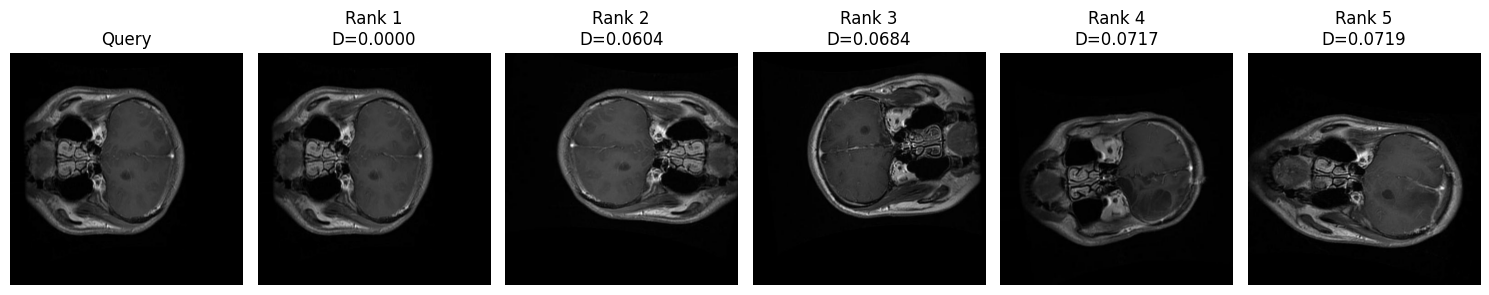

In [10]:

# Test su immagine di query
query_img = "Part1/brain_glioma/brain_glioma_0017.jpg"
find_k_similar_cosine(query_img, k=5)

Task 4:

In [14]:
import numpy as np
import os

def task4_predict_labels_resnetfc(query_img_path, k, extractor_fn, features, labels, metric="euclidean"):
    """
    Predict top-k labels for query image using ResNet FC features.
    extractor_fn: funzione che prende image_path e restituisce feature numpy array
    features: matrice numpy (N, d)
    labels: array di stringhe (N,)
    metric: "euclidean" o "cosine"
    """
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")

    def compute_metric(query_feat, target_feats, metric):
        query_feat = query_feat.reshape(1, -1)
        if metric == "euclidean":
            # distanza euclidea tra query_feat e tutti target_feats
            return np.linalg.norm(target_feats - query_feat, axis=1)
        elif metric == "cosine":
            # similarità coseno tra query_feat e tutti target_feats
            # sim = (A·B) / (|A||B|), distanza = 1 - sim
            dot_prod = np.dot(target_feats, query_feat.T).flatten()
            norm_feats = np.linalg.norm(target_feats, axis=1)
            norm_query = np.linalg.norm(query_feat)
            cosine_sim = dot_prod / (norm_feats * norm_query + 1e-10)
            cosine_dist = 1 - cosine_sim  # distanza coseno
            return cosine_dist
        else:
            raise ValueError("Metric must be 'euclidean' or 'cosine'")

    def predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        scores = []
        for label in unique_labels:
            class_feats = features[labels == label]
            dists = compute_metric(query_feat, class_feats, metric)
            scores.append(dists.mean())
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:  # cosine distanza: più piccola è meglio
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

    def predict_top_k_labels_prototype(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        prototypes = []
        for label in unique_labels:
            class_feats = features[labels == label]
            prototypes.append(class_feats.mean(axis=0))
        prototypes = np.vstack(prototypes)
        scores = compute_metric(query_feat, prototypes, metric)
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

    predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric)
    predict_top_k_labels_prototype(query_img_path, k, features, labels, metric)


In [ ]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"
task4_predict_labels_resnetfc(
    query_img, k=2,
    extractor_fn=lambda img: extract_fc_features_from_image(img, model, preprocess, device),
    features=feat_matrix_part1,
    labels=lbls_part1,
    metric="euclidean"
)

task4_predict_labels_resnetfc(
    query_img, k=2,
    extractor_fn=lambda img: extract_fc_features_from_image(img, model, preprocess, device),
    features=feat_matrix_part1,
    labels=lbls_part1,
    metric="cosine"
)


Task 5:

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def task5_latent_semantics_resnetfc(feature_model_path, technique, k):
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data['features']
    filenames = data['filenames']
    labels = data['labels']
    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa
            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")


def plot_latent_space_2d(X_transformed, labels, technique, k):
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


In [ ]:
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="svd", k=5)
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="lda", k=2)
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="kmeans", k=3)

task 6

In [18]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [19]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


In [ ]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

Task 7

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np


def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)

        svd = TruncatedSVD(n_components=k, random_state=42)
        latent = svd.fit_transform(X_scaled)

        # Salva scaler, SVD e i vettori latenti per la classe
        class_models[label] = {
            'scaler': scaler,
            'svd': svd,
            'latent_vectors': latent
        }
        # Calcola centroide nello spazio latente
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means


def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))
            x_latent = model['svd'].transform(x_scaled)
            dist = np.linalg.norm(x_latent - class_means[label])
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")
    print(classification_report(y_true, y_pred))


""" # ESEMPIO DI UTILIZZO:
def run_task7_resnetfc(part1_path, part2_path, k=10):
    X_train, y_train = part1['features'], part1['labels']
    X_test, y_test = part2['features'], part2['labels']

    # Addestramento
    print("[INFO] Calcolo dei latent semantics per ciascuna classe...")
    class_models, class_means = compute_latent_semantics_per_class(X_train, y_train, k)

    # Predizione
    print("[INFO] Classificazione delle immagini di Part 2...")
    y_pred = predict_label(X_test, class_models, class_means)

    # Valutazione
    print("[INFO] Valutazione del sistema:")
    evaluate(y_test, y_pred)"""


In [ ]:
run_task7_resnetfc("resnetfc_part1.npz", "resnetfc_part2.npz", k=10)


task 9

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))


Task10

In [28]:
# Classe LSH con quantizzazione

class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea (p-stable) con bucket width r.
    Ogni hash h_j(v) = floor((a_j · v + b_j) / r).

    Parametri:
      - num_layers   = L = numero di tavole hash
      - num_hashes   = h = numero di functions concatenati in ciascuna tavola
      - dim          = D = dimensione dei vettori di input
      - r            = bucket width (parte intera di quantizzazione)
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        # Prepara L tavole hash: ciascuna è un dict (chiave tuple di h interi -> lista di indici)
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]

        # Per ogni layer l=0..L-1, e per ogni j=0..h-1, genero:
        #   - a_lj  vettore gaussiano di dimensione D
        #   - b_lj  offset (uniforme in [0, r) )
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]

        # Memorizzerò i vettori originali di Part1 in questo array, shape=(N, D)
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        """
        Calcola l'hash (h interi) per il layer layer_idx su un vettore vec:
          h_j = floor((a_vectors[layer_idx][j] · vec + b_offsets[layer_idx][j]) / r)
        Ritorna una tupla di h interi.
        """
        keys = []
        a_vs = self.a_vectors[layer_idx]
        b_os = self.b_offsets[layer_idx]
        for j in range(self.h):
            a_j = a_vs[j]         # vettore dimensione D
            b_j = b_os[j]         # float in [0, r)
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            keys.append(h_val)
        return tuple(keys)

    def index(self, vectors: np.ndarray):
        """
        Costruisci l'indice LSH su un insieme di vettori di Part1:
          vectors: numpy array shape = (N, D)
        Al termine di questa chiamata:
          - self.data_vectors = vectors
          - self.hash_tables[l][hash_tuple] conterrà la lista di indici i per cui
            hash_tuple = _compute_hash_tuple(vectors[i], l).
        """
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Errore: dimensione vettore ({D}) ≠ atteso ({self.d})."

        # Inserisco ogni vettore in ciascuna tavola hash
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        """
        Esegui una query LSH per cercare i top_t vettori più vicini a q_vec.
        Restituisce:
          - top_results: lista di tuple (indice, distanza) ord. per dist. crescente
          - unique_count: numero di indici distinti considerati (cardinalità dei candidati)
          - total_checked: somma della lunghezza di tutti i bucket esaminati
        """
        assert q_vec.shape[0] == self.d, "Errore: dimensione query ≠ D."
        candidati = set()
        total_checked = 0

        # Per ciascun layer, ottengo la chiave polidimensionale e i suoi bucket
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        # Ora calcolo la distanza euclidea esatta tra q_vec e ciascun candidato
        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))

        # Ordino e prendo i primi top_t
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


In [29]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 12                        # numero di funzioni concatenati in ciascuna tavola
r = 0.2                       # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


[INFO] LSH quantizzato costruito: D=1000, L=10, h=12, r=0.2


In [30]:
#funzione per cercare top_k con LSH quantizzato

def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Cerca le k immagini di Part1 più simili a img_path (di Part2) usando LSH_EuclideanQuantized.
    Stampa:
      - i primi k risultati (file name, label, distanza)
      - il numero di immagini uniche considerate
      - il numero totale di controlli (somma delle lunghezze dei bucket)
    E poi visualizza (query + k risultati) con matplotlib.
    """
    # 1) Estrazione feature raw (900-dim) con la funzione esistente
    raw_q = np.array(extract_fc_features_from_image(img_path, model, preprocess, device), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec e L2 norm usati su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata a LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampa output testuale
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + primi k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



[LSH-Quant] Top 5 simili a: Part2/brain_glioma/brain_glioma_1409.jpg
[LSH-Quant] Immagini uniche considerate: 0
[LSH-Quant] Immagini totali controllate: 0


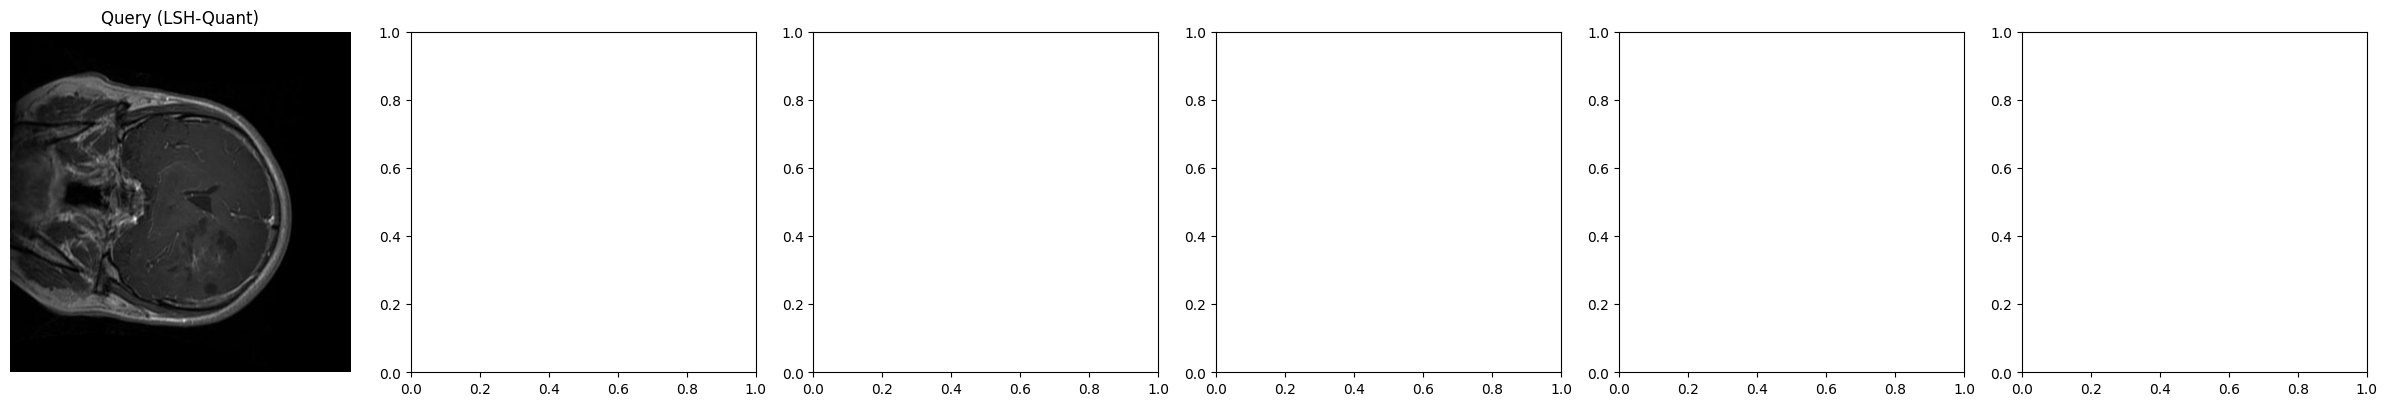

In [31]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1409.jpg"

k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)


Index LSH costruito: 5 tabelle, 1 hash per tabella.

----- Risultati LSH (Task 10) -----
Query: brain_glioma_1409.jpg
Num. candidati totali considerati (con duplicati): 784
Num. candidati unici considerati: 703
Indici dei top 5 vicini trovati: [355, 461, 958, 56, 920]

